In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ascanipek/skin-diseases")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-diseases


In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
# Drop classes by partial match
def drop_classes(dataset_dir, drop_keywords):
    for class_name in os.listdir(dataset_dir):
        for keyword in drop_keywords:
            if keyword.lower() in class_name.lower():
                class_path = os.path.join(dataset_dir, class_name)
                if os.path.isdir(class_path):
                    shutil.rmtree(class_path)
                    print(f"Ὕ Removed: {class_path}")
                else:
                    print(f"⚠️ Not found: {class_path}")

In [3]:
# Get class distribution
def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [4]:
# Create balanced dataset
def create_balanced_dataset(source_dir, target_dir, drop_keywords):
    os.makedirs(target_dir, exist_ok=True)
    class_counts = get_class_distribution(source_dir)
    remaining_classes = [c for c in class_counts if not any(keyword.lower() in c.lower() for keyword in drop_keywords)]
    if not remaining_classes:
        raise ValueError("No classes remain after dropping specified classes.")
    min_images = min(class_counts[c] for c in remaining_classes)
    print(f"Balancing {target_dir} to {min_images} images per class")

    for class_name in remaining_classes:
        class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)
        selected_images = images[:min_images]
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(target_class_path, img))
        print(f"Copied {len(selected_images)} images for class {class_name}")

In [5]:
# Random image display
def random_image(val_dir, val_class):
    folder = os.path.join(val_dir, val_class)
    all_images = os.listdir(folder)
    random.shuffle(all_images)
    img_path = os.path.join(folder, all_images[0])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"{val_class} — {all_images[0]}")
    plt.axis('off')
    plt.show()
    return img

# Check balance
def is_balanced(counts, tolerance=0.1):
    values = list(counts.values())
    avg = sum(values) / len(values)
    return all(abs(v - avg) / avg <= tolerance for v in values)

In [8]:
# Setup paths
src_dataset_path = '/kaggle/input/skin-diseases/kaggle'
dst_dataset_path = '/kaggle/working/skin-diseases'
if not os.path.exists(dst_dataset_path):
    shutil.copytree(src_dataset_path, dst_dataset_path)
    print(f"Dataset copied to: {dst_dataset_path}")

base_path = dst_dataset_path

Dataset copied to: /kaggle/working/skin-diseases


In [9]:

# Drop classes with partial matching
drop_keywords = ['akne', 'pigment']
drop_classes(os.path.join(base_path, 'train'), drop_keywords)
drop_classes(os.path.join(base_path, 'val'), drop_keywords)
drop_classes(os.path.join(base_path, 'test'), drop_keywords)

Ὕ Removed: /kaggle/working/skin-diseases/train/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/train/3. Akne
Ὕ Removed: /kaggle/working/skin-diseases/val/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/val/3. Akne
Ὕ Removed: /kaggle/working/skin-diseases/test/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/test/3. Akne


In [10]:
# Create balanced dataset
create_balanced_dataset(os.path.join(base_path, 'train'), '/kaggle/working/balanced_data/train', drop_keywords)
create_balanced_dataset(os.path.join(base_path, 'val'), '/kaggle/working/balanced_data/val', drop_keywords)
create_balanced_dataset(os.path.join(base_path, 'test'), '/kaggle/working/balanced_data/test', drop_keywords)

Balancing /kaggle/working/balanced_data/train to 4070 images per class
Copied 4070 images for class 5. Benign
Copied 4070 images for class 2. Ekzama
Copied 4070 images for class 6. Malign
Copied 4070 images for class 1. Enfeksiyonel
Balancing /kaggle/working/balanced_data/val to 508 images per class
Copied 508 images for class 5. Benign
Copied 508 images for class 2. Ekzama
Copied 508 images for class 6. Malign
Copied 508 images for class 1. Enfeksiyonel
Balancing /kaggle/working/balanced_data/test to 510 images per class
Copied 510 images for class 5. Benign
Copied 510 images for class 2. Ekzama
Copied 510 images for class 6. Malign
Copied 510 images for class 1. Enfeksiyonel


In [11]:
# Load datasets
train_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/train',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=True,
    seed=42
)
val_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/val',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=False,
    seed=42
)
test_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/test',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 16280 files belonging to 4 classes.
Found 2032 files belonging to 4 classes.
Found 2040 files belonging to 4 classes.


In [12]:
# Check distributions
print("Train Distribution:", get_class_distribution('/kaggle/working/balanced_data/train'))
print("Validation Distribution:", get_class_distribution('/kaggle/working/balanced_data/val'))
print("Test Distribution:", get_class_distribution('/kaggle/working/balanced_data/test'))

Train Distribution: {'5. Benign': 4070, '2. Ekzama': 4070, '6. Malign': 4070, '1. Enfeksiyonel': 4070}
Validation Distribution: {'5. Benign': 508, '2. Ekzama': 508, '6. Malign': 508, '1. Enfeksiyonel': 508}
Test Distribution: {'5. Benign': 510, '2. Ekzama': 510, '6. Malign': 510, '1. Enfeksiyonel': 510}


In [13]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3)

In [14]:
# Augmentation
data_aug = tf.keras.Sequential([
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
])

# Build model with L1 + L2 regularization
l1_l2_reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)


In [15]:
base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet')
for layer in base_model.layers[-1:]:
    layer.trainable = True

inputs = layers.Input(shape=(260, 260, 3))
x = data_aug(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(0.2),
                 kernel_initializer='he_normal',
                 kernel_regularizer=l1_l2_reg)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(4, kernel_regularizer=l1_l2_reg)(x)
outputs = layers.Activation("softmax", dtype='float32')(x)
model = tf.keras.Model(inputs, outputs)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Compile and train
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, None, None,     │     7,768,569 │
│                                 │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,130,301 (31.01 MB)

 Trainable params: 8,062,726 (30.76 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 449s 754ms/step - accuracy: 0.6089 - loss: 1.0576 - val_accuracy: 0.6644 - val_loss: 1.4324 - learning_rate: 0.0010
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 430s 739ms/step - accuracy: 0.7257 - loss: 0.7917 - val_accuracy: 0.6895 - val_loss: 1.4566 - learning_rate: 0.0010
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 383s 742ms/step - accuracy: 0.7517 - loss: 0.6826 - val_accuracy: 0.7116 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 4/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 384s 746ms/step - accuracy: 0.7783 - loss: 0.6091 - val_accuracy: 0.7347 - val_loss: 0.8110 - learning_rate: 0.0010
Epoch 5/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 378s 738ms/step - accuracy: 0.7961 - loss: 0.5522 - val_accuracy: 0.7539 - val_loss: 0.7097 - learning_rate: 0.0010
Epoch 6/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 376s 739ms/step - accuracy: 0.8124 - loss: 0.5099 - val_accuracy: 0.6944 - val_loss: 1.2517 - learning_rate: 0.0010
Epoch 7/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 378s 732ms/step - accura

In [25]:
# prompt: write code for checking accuracy

loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.8291 - loss: 0.7148
Test Loss: 0.6583
Test Accuracy: 0.8417


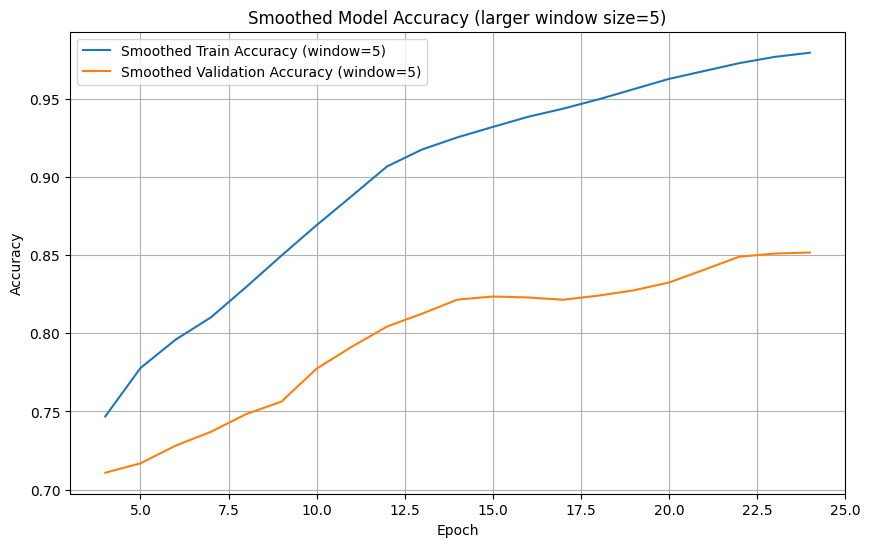

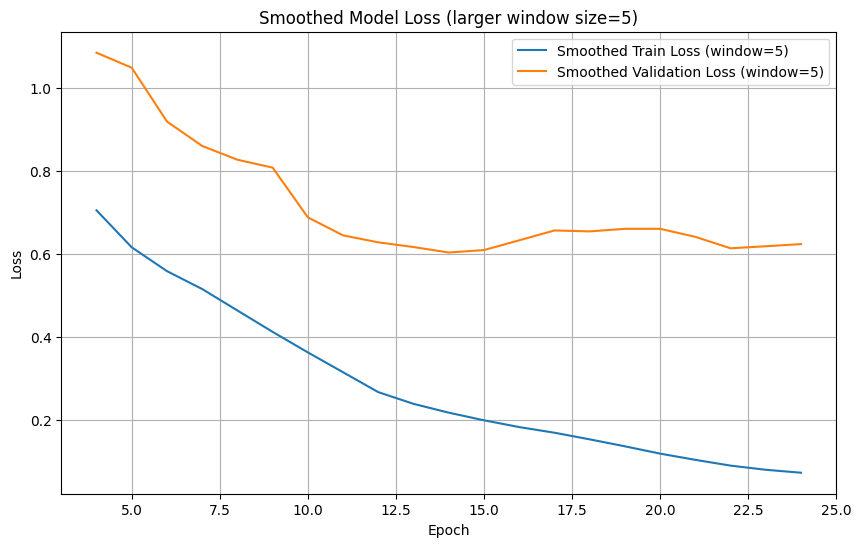

In [27]:
# prompt: i need more soomth curve

# To get a smoother curve, increase the window size for the rolling average.
# Let's increase the window size and plot again.

# Increase the window size for more smoothing
window_size = 5 # You can experiment with different window sizes

# Convert history to pandas DataFrames for easier manipulation
history_df = pd.DataFrame(history.history)

# Smooth the accuracy curves with the new window size
smoothed_train_accuracy_large_window = history_df['accuracy'].rolling(window=window_size).mean()
smoothed_val_accuracy_large_window = history_df['val_accuracy'].rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_train_accuracy_large_window, label='Smoothed Train Accuracy (window={})'.format(window_size))
plt.plot(smoothed_val_accuracy_large_window, label='Smoothed Validation Accuracy (window={})'.format(window_size))
plt.title(f'Smoothed Model Accuracy (larger window size={window_size})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Smooth the loss curves with the new window size
smoothed_train_loss_large_window = history_df['loss'].rolling(window=window_size).mean()
smoothed_val_loss_large_window = history_df['val_loss'].rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_train_loss_large_window, label='Smoothed Train Loss (window={})'.format(window_size))
plt.plot(smoothed_val_loss_large_window, label='Smoothed Validation Loss (window={})'.format(window_size))
plt.title(f'Smoothed Model Loss (larger window size={window_size})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Predicting on image: /kaggle/working/balanced_data/test/2. Ekzama/05keratosisPilaris080706.jpg
Found 510 files.
510/510 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step
Predicted class: 2. Ekzama
Confidence: 0.3193
Raw predictions: [[4.7337520e-01 5.2584815e-01 7.6483091e-04 1.1767817e-05]
 [3.6509473e-02 9.6296805e-01 3.9844314e-04 1.2407987e-04]
 [1.7086165e-04 9.9980980e-01 1.1110935e-05 8.2109300e-06]
 ...
 [1.3181443e-03 9.9831378e-01 1.0126503e-05 3.5792266e-04]
 [5.8467846e-05 9.9994040e-01 7.9917584e-07 3.4375077e-07]
 [9.3050504e-01 5.0274175e-02 4.9468846e-04 1.8726191e-02]]


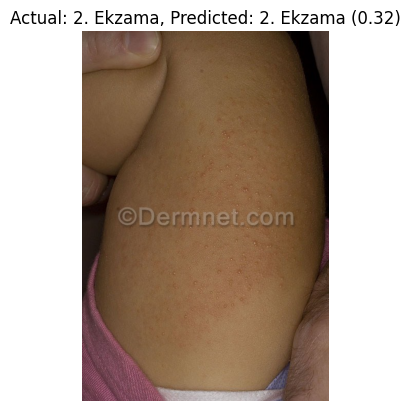

In [29]:
# prompt: write code for prediction

# Function for making a prediction on a single image
def predict_image(model, img_path, class_names):
    img = image_dataset_from_directory(
        directory=os.path.dirname(img_path),
        labels='inferred',
        label_mode=None, # No labels needed for prediction
        image_size=(260, 260),
        batch_size=1,
        shuffle=False,
        interpolation='nearest', # Maintain pixel values
        follow_links=True,
        crop_to_aspect_ratio=False,
        seed=None
    )
    # Use the dataset for prediction
    predictions = model.predict(img)
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = tf.nn.softmax(predictions, axis=1).numpy()[0][predicted_class_index]

    return predicted_class_name, confidence, predictions

# Get the class names from the test data directory
class_names = test_data.class_names

# Example prediction on a random image from the test set
# First, let's get a random class and a random image from that class
random_class = random.choice(class_names)
random_class_dir = os.path.join('/kaggle/working/balanced_data/test', random_class)
random_image_filename = random.choice(os.listdir(random_class_dir))
random_image_path = os.path.join(random_class_dir, random_image_filename)

print(f"Predicting on image: {random_image_path}")

# Make the prediction
predicted_class, confidence, raw_predictions = predict_image(model, random_image_path, class_names)

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")
print(f"Raw predictions: {raw_predictions}")

# Display the image and the prediction
img_display = mpimg.imread(random_image_path)
plt.imshow(img_display)
plt.title(f"Actual: {random_class}, Predicted: {predicted_class} ({confidence:.2f})")
plt.axis('off')
plt.show()


In [31]:
# prompt: write code to save model

model.save("skin_disease_model.h5")
print("Model saved successfully to skin_disease_model.h5")

Model saved successfully to skin_disease_model.h5
